In [49]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from pyod.models.knn import KNN
from pyod.models.lof import LOF

In [50]:
# Generate 2 clusters with custom parameters

X, y = make_blobs(
    n_samples=[500],
    random_state=1,
    centers=[(0, 0)]
)

print(f"Generated {len(X)} samples")
print(f"Shape: {X.shape}")
print(f"Cluster distribution: {np.bincount(y)}")

Generated 500 samples
Shape: (500, 2)
Cluster distribution: [500]


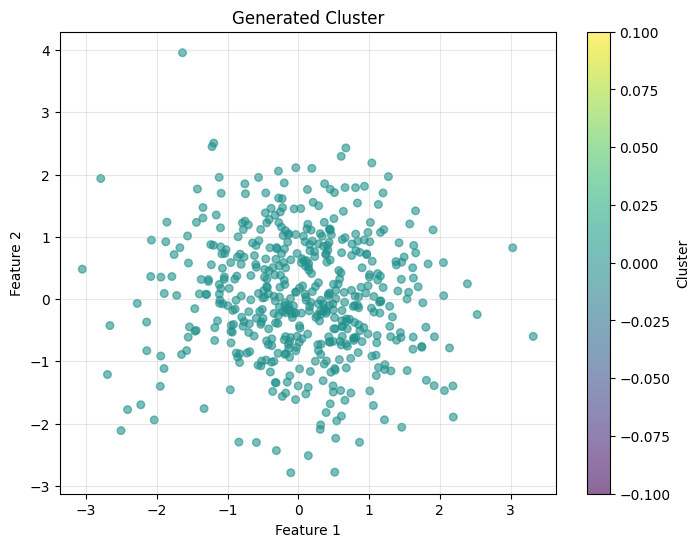

In [51]:
# Visualize the generated clusters
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=30, alpha=0.6)
plt.title('Generated Cluster')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

In [52]:
np.random.seed(1)
# Project data onto 5 random unit vectors
num_vectors = 5
num_bins = 200
proj_vectors = np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0], [0, 1]], size=num_vectors)

{'proj_vectors': array([[ 1.62434536, -0.61175641],
       [-0.52817175, -1.07296862],
       [ 0.86540763, -2.3015387 ],
       [ 1.74481176, -0.7612069 ],
       [ 0.3190391 , -0.24937038]]),
 'unit_vectors': array([[ 0.93583067, -0.35244993],
       [-0.44164435, -0.89719021],
       [ 0.35195429, -0.93601719],
       [ 0.91657125, -0.39987142],
       [ 0.78787929, -0.61582971]])}
{'num_bins': 200,
 'num_vectors': 5,
 'projected_shapes': [(500,), (500,), (500,), (500,), (500,)]}


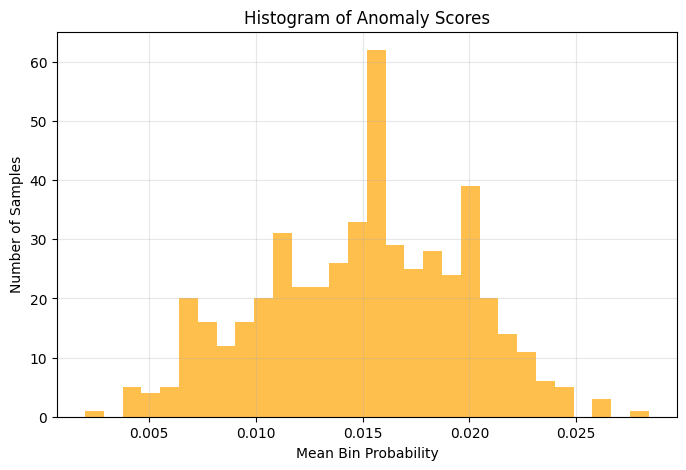

In [53]:
import pprint 

# Normalize projection vectors to unit length
unit_vectors = proj_vectors / np.linalg.norm(proj_vectors, axis=1, keepdims=True)
pprint.pprint({"unit_vectors": unit_vectors, "proj_vectors": proj_vectors})

# Project data onto each unit vector
projected = [X @ v for v in unit_vectors]
pprint.pprint({"projected_shapes": [proj.shape for proj in projected],
    "num_vectors": num_vectors,
    "num_bins": num_bins})
# Compute histograms and probabilities 
histograms = []
bin_edges = []
bin_probs = []
for proj in projected:
    min_val, max_val = proj.min(), proj.max()
    range_margin = 0.2 * (max_val - min_val)
    hist_range = (min_val - range_margin, max_val + range_margin)
    hist, edges = np.histogram(proj, bins=num_bins, range=hist_range)
    prob = hist / hist.sum()
    histograms.append(hist)
    bin_edges.append(edges)
    bin_probs.append(prob)

# For each sample, get the bin index for each projection and corresponding probability
anomaly_scores = []
for i in range(X.shape[0]):
    sample_probs = []
    for j in range(num_vectors):
        proj_val = projected[j][i]
        # Find the bin index for this value
        bin_idx = np.searchsorted(bin_edges[j], proj_val, side='right') - 1
        # Clamp bin_idx to valid range
        bin_idx = np.clip(bin_idx, 0, num_bins - 1)
        sample_probs.append(bin_probs[j][bin_idx])
    # Anomaly score: mean probability ,lower means more anomalous
    anomaly_scores.append(np.mean(sample_probs))

anomaly_scores = np.array(anomaly_scores)

# histogram of anomaly scores
plt.figure(figsize=(8, 5))
plt.hist(anomaly_scores, bins=30, color='orange', alpha=0.7)
plt.title('Histogram of Anomaly Scores')
plt.xlabel('Mean Bin Probability')
plt.ylabel('Number of Samples')
plt.grid(True, alpha=0.3)
plt.show()

In [54]:
dataset = np.random.uniform(low=-3, high=3, size=(500, 2))


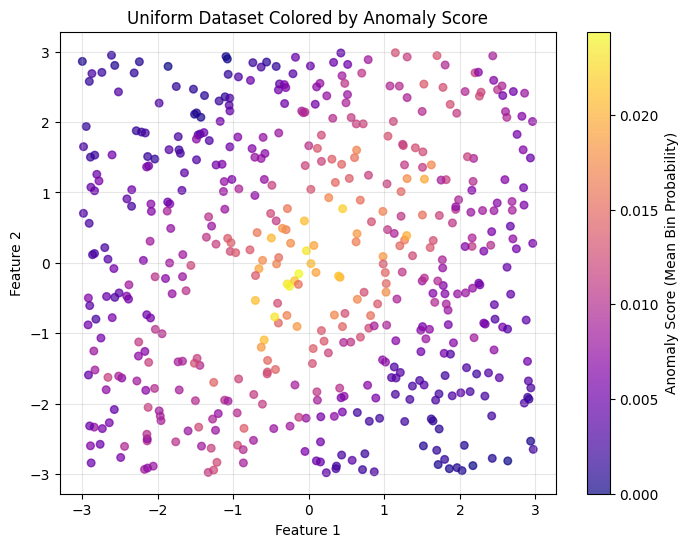

In [55]:
uniform_projected = [dataset @ v for v in unit_vectors]

uniform_anomaly_scores = []
for i in range(dataset.shape[0]):
    sample_probs = []
    for j in range(num_vectors):
        proj_val = uniform_projected[j][i]
        bin_idx = np.searchsorted(bin_edges[j], proj_val, side='right') - 1
        bin_idx = np.clip(bin_idx, 0, num_bins - 1)
        sample_probs.append(bin_probs[j][bin_idx])
    uniform_anomaly_scores.append(np.mean(sample_probs))
uniform_anomaly_scores = np.array(uniform_anomaly_scores)

plt.figure(figsize=(8, 6))
sc = plt.scatter(dataset[:, 0], dataset[:, 1], c=uniform_anomaly_scores, cmap='plasma', s=30, alpha=0.7)
plt.title('Uniform Dataset Colored by Anomaly Score')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(sc, label='Anomaly Score (Mean Bin Probability)')
plt.grid(True, alpha=0.3)
plt.show()